In [72]:
import numpy as np
import matplotlib.pyplot as plt
from backend import TwoDimNav, PC_AC_agent

In [73]:
train_episodes = 1000

tmax = 100
goalsize = 0.25
startcoord = 'center'
goalcoord = [0.7, 0.7]
testgoalcoord = [-0.7,-0.7]

seed = np.random.choice(np.arange(100),1)  # choose a specific seed for consistency
print(seed)
env = TwoDimNav(startcoord=startcoord, goalcoord=goalcoord, goalsize=goalsize, tmax=tmax, seed=seed)

[86]


In [74]:
# initialize agent
alr = 0.00  # 0.0075
clr = 0.001  # 0.025

agent = PC_AC_agent(alr=alr, clr=clr)

In [75]:
wClms = agent.wC.copy()
lmslr = 0.01

In [76]:

latency = []
aprob = []
success = 0
hebbtds = []
lmstds = []

features = []
hebbvals = []
lmsvals = []
for e in range(train_episodes):
    state, goal, eucdist, done = env.reset()

    hebbval = []
    lmsval = []
    hebbtd = []
    lmstd = []
    storehtd = []
    feature = []

    for t in range(tmax):
    
        onehotg = agent.get_action(state)

        feature.append(state)

        # eucdist is euclediean distance to goal, done is a sparse scalar reward signal 
        newstate, eucdist, done = env.step(onehotg) 

        # use scalar sparse reward signal to update TD error
        agent.learn(newstate=newstate, reward=done)


        # LMS update end of trial
        V = np.matmul(agent.get_pc(state), wClms)
        V1 = np.matmul(agent.get_pc(newstate), wClms)
        td = int(done) + agent.gamma * V1 - V

        # store value
        hebbval.append(agent.V)
        lmsval.append(V)

        hebbtd.append(agent.td)
        lmstd.append(td)

        storehtd.append(agent.h[:,None]*td)

        state = newstate.copy()

        if done:
            success+=1
            break
            
    # if e % 25 == 0:
    #     agent.plot_maps(env)

    hebbvals.append(hebbval)
    lmsvals.append(lmsval)

    hebbtds.append(hebbtd)
    lmstds.append(lmstd)
    features.append(feature)

    # update lms
    wClms += lmslr * np.mean(np.array(storehtd),axis=0)

    latency.append(t)
    #print(agent.wC.max(), agent.wA.max())
    print(f'E {e+1}/ {train_episodes}, R {done}, t {t}')


print(f"Completion {success}/{train_episodes}")

[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 1/ 1000, R True, t 55
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 2/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 3/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 4/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 5/ 1000, R True, t 79
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 6/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 7/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 8/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 9/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 10/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 11/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 12/ 1000, R True, t 55
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 13/ 1000, R True, t 25
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 14/ 1000, R True, t 79
[0. 0.]
State: [0. 0.], Goal: [0.7 0.7]
E 15/ 1000, R False, t 99
[0. 0.]
State: [0. 0.], 

In [77]:
# get true V for all episodes
hebbval_hats = []
lmsval_hats = []
hebberr = []
lmserr = []

for e in range(train_episodes):
    hebbval_hat = []
    lmsval_hat = []
    for i, feature in enumerate(features[e]):
        h = agent.get_pc(feature)

        hebbval_hat.append(np.matmul(h, agent.wC))
        lmsval_hat.append(np.matmul(h, wClms))

    hebbval_hats.append(hebbval_hat)
    lmsval_hats.append(lmsval_hat)

    hebberr.append(np.mean((np.array(hebbval_hats[e]) - np.array(hebbvals[e]))**2))
    lmserr.append(np.mean((np.array(lmsval_hats[e]) - np.array(lmsvals[e]))**2))

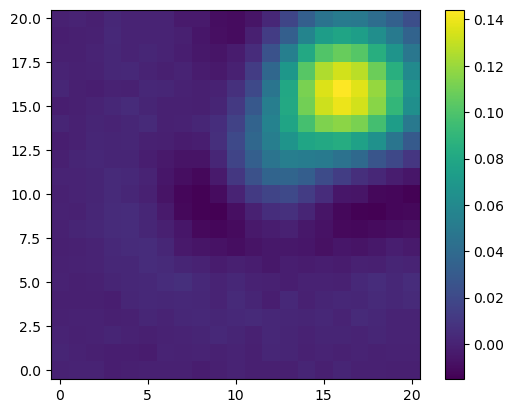

In [78]:
plt.figure()
plt.imshow(agent.wC.reshape(agent.npc, agent.npc), origin='lower')
plt.colorbar()

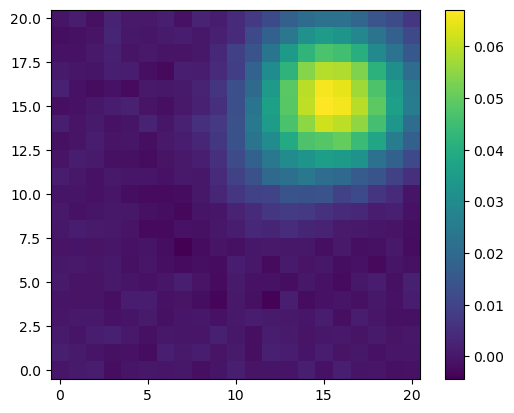

In [79]:
plt.figure()
plt.imshow(wClms.reshape(agent.npc, agent.npc), origin='lower')
plt.colorbar()

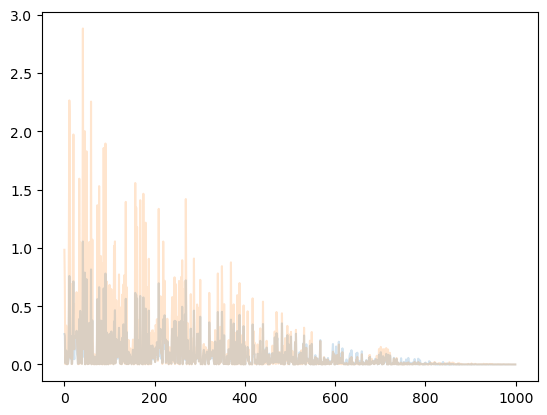

In [81]:
plt.figure()
plt.plot(lmserr,alpha=0.2)
plt.plot(hebberr,alpha=0.2)